## Understand the dataset

- Loading data
- Number of classes and the number of images available for each class
- The distribution of classes
- Sample images


### Loading data

In [188]:
import numpy as np
import pandas as pd
from keras.layers import Conv2D, Dense, Dropout, Flatten
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import cv2
from glob import glob
from matplotlib import pyplot as plt
from numpy import floor
import random
import os
from PIL import Image
import glob
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow import keras
from keras.callbacks import TensorBoard
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

In [16]:
base_path = '/kaggle/input/plant-village-dataset-updated/Apple/Train/'

### Number of classes and the number of images available for each class

In [4]:
classes = os.listdir(base_path)

num_images = []
for class_name in classes:
    class_path = os.path.join(base_path, class_name)
    num_images = len(glob(os.path.join(class_path, "*.JPG")))
    print(f"Class: {class_name}, Number of Images: {num_images}")
    

Class: Healthy, Number of Images: 2008
Class: Apple Scab, Number of Images: 2016
Class: Cedar Apple Rust, Number of Images: 1760
Class: Black Rot, Number of Images: 1987


### Checking the distribution of classes

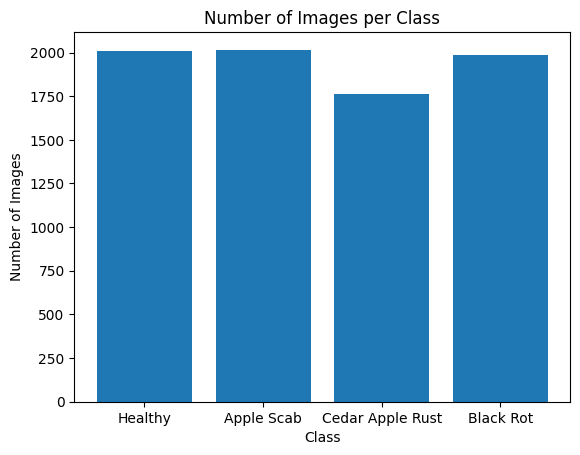

In [5]:
num_images = []
for class_name in classes:
    class_path = os.path.join(base_path, class_name)
    num_images.append(len(glob(os.path.join(class_path, "*.JPG"))))

# Create a bar plot
plt.bar(classes, num_images)
plt.title("Number of Images per Class")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()

### Sample Images

Samples images for category Apple Scab


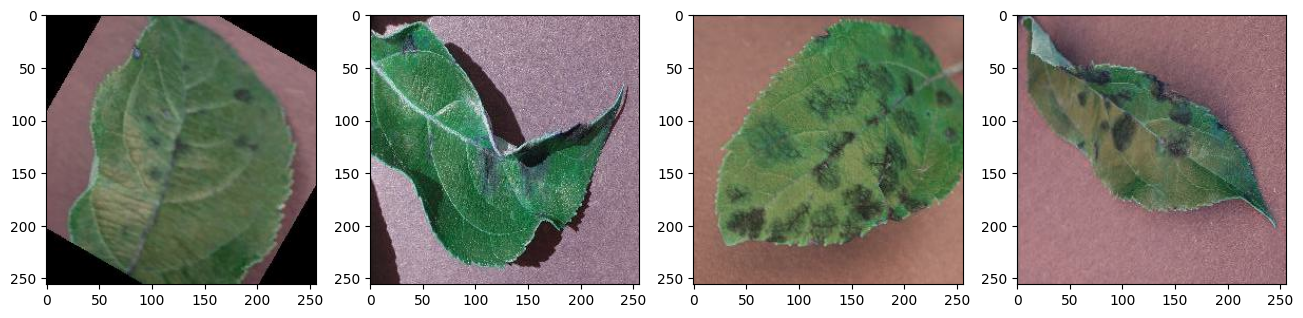

Samples images for category Black Rot


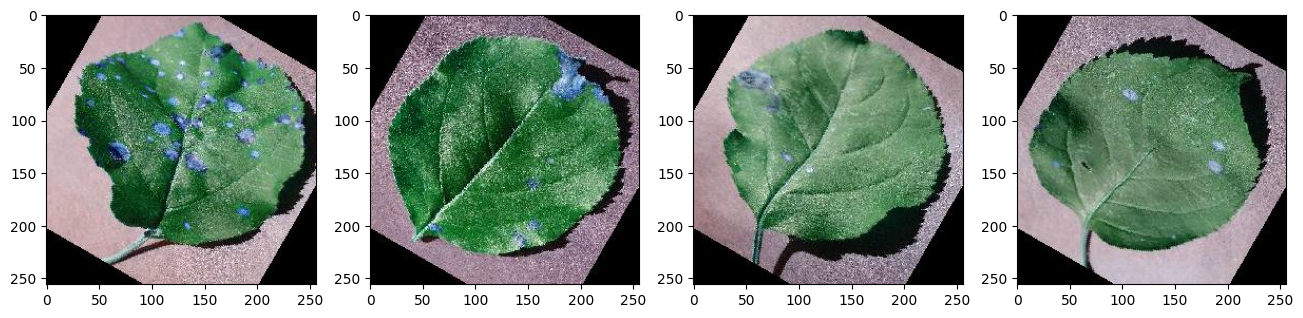

Samples images for category Cedar Apple Rust


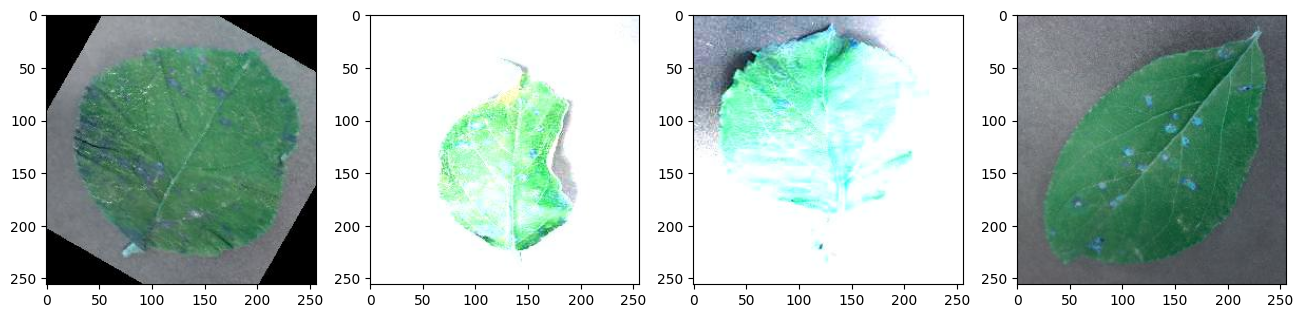

Samples images for category Healthy


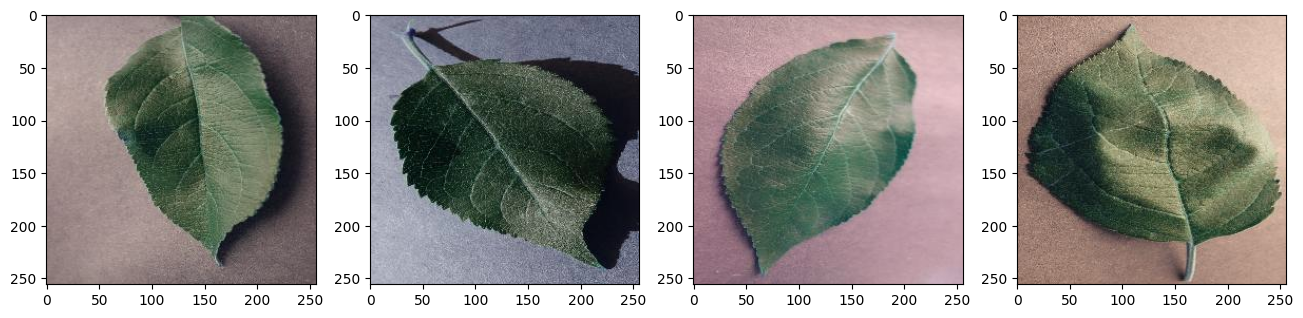

In [17]:
def plot_samples(category):
    if category not in classes:
        print("Invalid category!")
        return
    print("Samples images for category " + category)
    img_path = base_path + category + '/**/*.JPG'
    path_contents = glob(img_path, recursive=True)
    
    plt.figure(figsize=(16,16))
    imgs = random.sample(path_contents, 4)
    plt.subplot(141)
    plt.imshow(cv2.imread(imgs[0]))
    plt.subplot(142)
    plt.imshow(cv2.imread(imgs[1]))
    plt.subplot(143)
    plt.imshow(cv2.imread(imgs[2]))
    plt.subplot(144)
    plt.imshow(cv2.imread(imgs[3]))
    plt.show()
    return

plot_samples('Apple Scab')
plot_samples('Black Rot')
plot_samples('Cedar Apple Rust')
plot_samples('Healthy')



## Data preprocessing

- Checking images size and pixel values
- Resizing and Normalizing 
- Data augmentation

### Checking image size

In [20]:
# List all directories in the base directory
dirs = os.listdir(base_path)

for dir_name in dirs:
    # Check if the directory is a valid directory
    if os.path.isdir(os.path.join(base_path, dir_name)):
        # Open the output file for writing
        output_file = open(dir_name + "_sizes.txt", "w")
        # List all image files in the directory
        image_files = os.listdir(os.path.join(base_path, dir_name))
        for file_name in image_files:
            # Check if the file is an image file
            if file_name.endswith(".JPG"):
                # Open the image file and get its size
                img_path = os.path.join(base_path, dir_name, file_name)
                img = cv2.imread(img_path)
                size = img.shape[:2]
                # Write the size information to the output file
                output_file.write(file_name + ": " + str(size) + "\n")
        # Close the output file
        output_file.close()

In [47]:
# Load the data from the *_sizes.txt files
Apple_Scab_sizes = pd.read_csv('/kaggle/working/Apple Scab_sizes.txt', sep=':', header=None, names=['JPG', 'size'])
Black_Rot_sizes = pd.read_csv('/kaggle/working/Black Rot_sizes.txt', sep=':', header=None, names=['JPG', 'size'])
Cedar_Apple_Rust_sizes = pd.read_csv('/kaggle/working/Cedar Apple Rust_sizes.txt', sep=':', header=None, names=['JPG', 'size'])
Healthy_sizes = pd.read_csv('/kaggle/working/Healthy_sizes.txt', sep=':', header=None, names=['JPG', 'size'])

In [60]:
print('Apple Scab:\n', Apple_Scab_sizes.head())
print('Black Rot:\n', Black_Rot_sizes.head())
print('Cedar Apple Rust:\n', Cedar_Apple_Rust_sizes.head())
print('Healthy:\n', Healthy_sizes.head())

Apple Scab:
                                                  JPG         size
0  c4e2b47d-d3c9-418e-9e60-78cead67c5d7___FREC_Sc...   (256, 256)
1  9555b45b-0080-4d26-8b54-a343b9bf0ffc___FREC_Sc...   (256, 256)
2  5a178d63-372d-48c4-adb8-d616130ba3f0___FREC_Sc...   (256, 256)
3  0a6812de-7416-4ffe-aba9-307599a02c84___FREC_Sc...   (256, 256)
4  6b5e1187-9b7b-4b4c-912f-b2175619f35f___FREC_Sc...   (256, 256)
Black Rot:
                                                  JPG         size
0  b970ac93-7f26-41ae-a5ed-fc509e209c12___JR_FrgE...   (256, 256)
1  c762e867-0f8b-459e-b870-10090256d9bf___JR_FrgE...   (256, 256)
2  24420d48-c47b-4e67-959a-bf28131abbdc___JR_FrgE...   (256, 256)
3  a55923f0-3b82-40ee-8211-720503bc00af___JR_FrgE...   (256, 256)
4  64b3612f-e972-44c5-8ef0-c9ac194c34a9___JR_FrgE...   (256, 256)
Cedar Apple Rust:
                                                  JPG         size
0  d3df6ac8-4b20-460a-ad91-68e50d49078c___FREC_C....   (256, 256)
1  5367e167-14f3-4d65-bd93-4c4b6

In [58]:
print('Apple_Scab_sizes:', Apple_Scab_sizes['size'].unique())
print('Black_Rot_sizes', Black_Rot_sizes['size'].unique())
print('Cedar_Apple_Rust_sizes', Cedar_Apple_Rust_sizes['size'].unique())
print('Healthy_sizes', Healthy_sizes['size'].unique())

Apple_Scab_sizes: [' (256, 256)']
Black_Rot_sizes [' (256, 256)']
Cedar_Apple_Rust_sizes [' (256, 256)']
Healthy_sizes [' (256, 256)']


Based on the above information, it seems like all images in each of the four classes have the same size of (256, 256). 

### Checking pixel values

Displaying both the colored image and grayscale image, may give an idea of the differences between them, and whether or not normalizing pixel values is necessary.

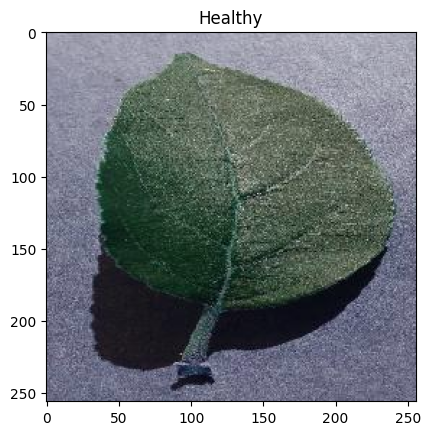

In [96]:
# Display the first image of the Healthy category in colour

for category in classes:
    path = os.path.join(base_path, category)
    for img in os.listdir(path):
        img_array_healthy = cv2.imread(os.path.join(path, img))
        plt.imshow(img_array_healthy)
        plt.title(category)
        plt.show()
        break
    break

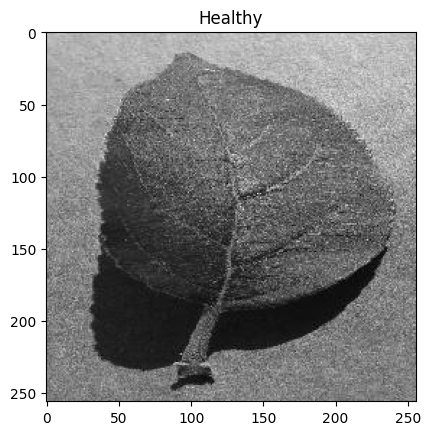

In [97]:
# Display the first image of the Healthy category in gray

for category in classes:
    path = os.path.join(base_path, category)
    for img in os.listdir(path):
        img_array_gray_healthy = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        plt.imshow(img_array_gray_healthy, cmap='gray')
        plt.title(category)
        plt.show()
        break
    break

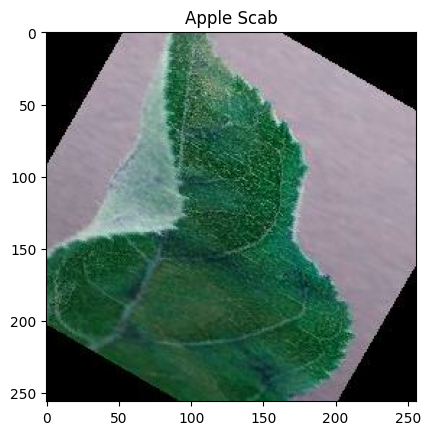

In [98]:
# Display the first image of the Apple Scab category in colour

counter = 0
for category in classes:
    path = os.path.join(base_path, category)
    for img in os.listdir(path):
        img_array_apple_scab = cv2.imread(os.path.join(path, img))
        if category == classes[1] and counter == 0:
            plt.imshow(img_array_apple_scab)
            plt.title(category)
            plt.show()
            counter += 1
        break
    if counter > 0:
        break

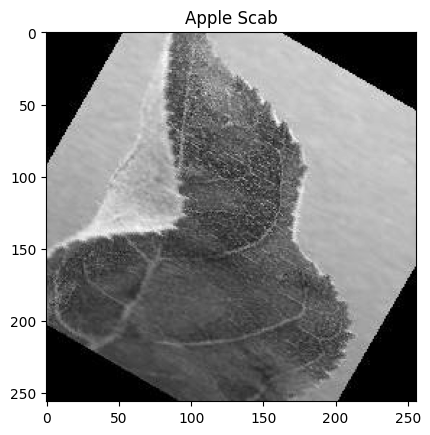

In [99]:
# Display the first image of the Apple Scab category in gray

counter = 0
for category in classes:
    path = os.path.join(base_path, category)
    for img in os.listdir(path):
        img_array_gray_apple_scab = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        if category == classes[1] and counter == 0:
            plt.imshow(img_array_gray_apple_scab, cmap='gray')
            plt.title(category)
            plt.show()
            counter += 1
        break
    if counter > 0:
        break

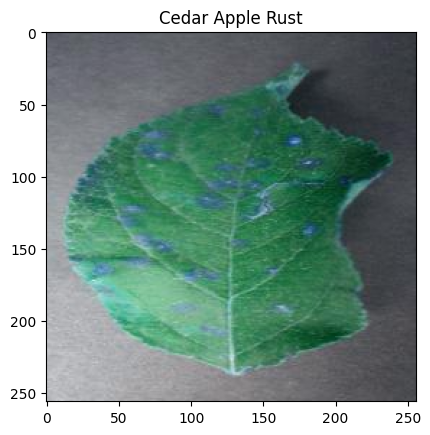

In [102]:
# Display the first image of the Cedar Apple Rust category in colour

counter = 0
for category in classes:
    path = os.path.join(base_path, category)
    for img in os.listdir(path):
        img_array_cedar_apple_rust = cv2.imread(os.path.join(path, img))
        if category == classes[2] and counter == 0:
            plt.imshow(img_array_cedar_apple_rust)
            plt.title(category)
            plt.show()
            counter += 1
        break
    if counter > 0:
        break

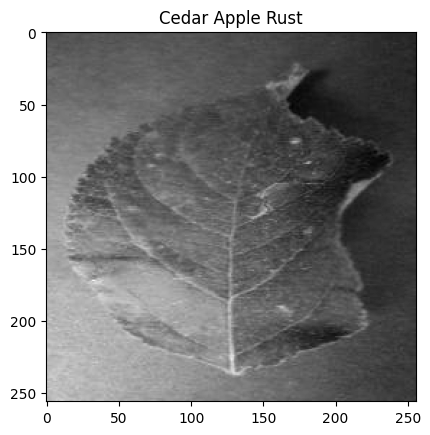

In [103]:
# Display the first image of the Cedar Apple Rust category in gray

counter = 0
for category in classes:
    path = os.path.join(base_path, category)
    for img in os.listdir(path):
        img_array_gray_cedar_apple_rust = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        if category == classes[2] and counter == 0:
            plt.imshow(img_array_gray_cedar_apple_rust, cmap='gray')
            plt.title(category)
            plt.show()
            counter += 1
        break
    if counter > 0:
        break

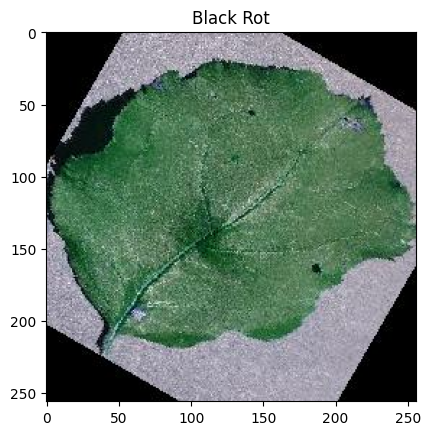

In [106]:
# Display the first image of the Black Rot category in colour

counter = 0
for category in classes:
    path = os.path.join(base_path, category)
    for img in os.listdir(path):
        img_array_black_rot = cv2.imread(os.path.join(path, img))
        if category == classes[3] and counter == 0:
            plt.imshow(img_array_black_rot)
            plt.title(category)
            plt.show()
            counter += 1
        break
    if counter > 0:
        break

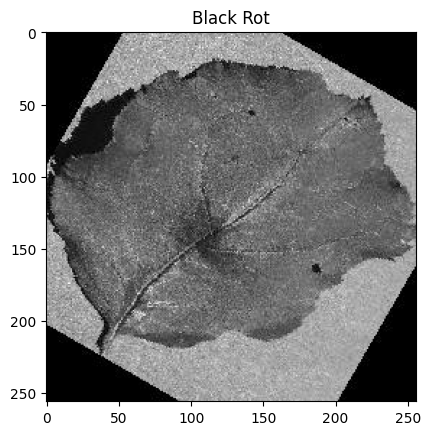

In [105]:
# Display the first image of the Black Rot category in gray

counter = 0
for category in classes:
    path = os.path.join(base_path, category)
    for img in os.listdir(path):
        img_array_gray_black_rot = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        if category == classes[3] and counter == 0:
            plt.imshow(img_array_gray_black_rot, cmap='gray')
            plt.title(category)
            plt.show()
            counter += 1
        break
    if counter > 0:
        break

In [109]:
print(img_array_healthy.shape)
print(img_array_gray_healthy.shape)
print(img_array_apple_scab.shape)
print(img_array_gray_apple_scab.shape)
print(img_array_cedar_apple_rust.shape)
print(img_array_gray_cedar_apple_rust.shape)
print(img_array_black_rot.shape)
print(img_array_gray_black_rot.shape)

(256, 256, 3)
(256, 256)
(256, 256, 3)
(256, 256)
(256, 256, 3)
(256, 256)
(256, 256, 3)
(256, 256)


### Resizing and Normalizing

Since the images are in the same size, resizing will be considered later if needed to improve the performance of the model or to reduce the computational cost.

### Data augmentation

In [117]:
# set the paths to the train, test, and validation data
train_dir = '/kaggle/input/plant-village-dataset-updated/Apple/Train/'
test_dir = '/kaggle/input/plant-village-dataset-updated/Apple/Test/'
val_dir = '/kaggle/input/plant-village-dataset-updated/Apple/Val'

In [119]:
# use the ImageDataGenerator to rescale the images and apply data augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

In [120]:
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

## Modelling

In [118]:
# set the image size and batch size
img_size = (256, 256)
batch_size = 32

In [121]:
# create the train, test, and validation generators
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=img_size,
                                                    batch_size=batch_size,
                                                    class_mode='categorical')


test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=img_size,
                                                  batch_size=batch_size,
                                                  class_mode='categorical')

val_generator = val_datagen.flow_from_directory(val_dir,
                                                target_size=img_size,
                                                batch_size=batch_size,
                                                class_mode='categorical')

Found 7771 images belonging to 4 classes.
Found 196 images belonging to 4 classes.
Found 1747 images belonging to 4 classes.


In [150]:
log_dir = "logs/fit/"
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# build and train the model
model = Sequential()

# Add convolutional layer with 32 filters, 3x3 kernel size, and ReLU activation
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))

# Add max pooling layer with 2x2 pool size
model.add(MaxPooling2D((2, 2)))

# Add another convolutional layer with 64 filters, 3x3 kernel size, and ReLU activation
model.add(Conv2D(64, (3, 3), activation='relu'))

# Add another max pooling layer with 2x2 pool size
model.add(MaxPooling2D((2, 2)))

# Flatten the output of the convolutional layers
model.add(Flatten())

# Add a fully connected layer with 128 units and ReLU activation
model.add(Dense(128, activation='relu'))

# Add an output layer with softmax activation and number of units equal to the number of classes
model.add(Dense(4, activation='softmax'))

# Compile the model with categorical cross-entropy loss and Adam optimizer
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [137]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 246016)            0         
                                                                 
 dense_8 (Dense)             (None, 128)              

In [151]:
%%time
history = model.fit(train_generator, epochs=10, validation_data=val_generator, callbacks=[tensorboard_callback])

Epoch 1/10
243/243 [==============================] - 162s 659ms/step - loss: 0.9095 - accuracy: 0.7172 - val_loss: 0.7221 - val_accuracy: 0.8042
Epoch 2/10
243/243 [==============================] - 163s 669ms/step - loss: 0.3443 - accuracy: 0.8689 - val_loss: 0.7735 - val_accuracy: 0.7785
Epoch 3/10
243/243 [==============================] - 161s 663ms/step - loss: 0.2567 - accuracy: 0.9098 - val_loss: 0.4816 - val_accuracy: 0.8661
Epoch 4/10
243/243 [==============================] - 164s 674ms/step - loss: 0.1930 - accuracy: 0.9322 - val_loss: 0.3073 - val_accuracy: 0.9027
Epoch 5/10
243/243 [==============================] - 162s 666ms/step - loss: 0.2240 - accuracy: 0.9194 - val_loss: 0.2695 - val_accuracy: 0.9170
Epoch 6/10
243/243 [==============================] - 161s 661ms/step - loss: 0.1607 - accuracy: 0.9399 - val_loss: 0.1579 - val_accuracy: 0.9439
Epoch 7/10
243/243 [==============================] - 164s 675ms/step - loss: 0.1584 - accuracy: 0.9435 - val_loss: 0.3042 -

In [156]:
!pip install tensorboard

In [161]:
%reload_ext tensorboard
%tensorboard --logdir=logs/fit/

Reusing TensorBoard on port 6006 (pid 14235), started 0:01:36 ago. (Use '!kill 14235' to kill it.)

### Training curve

In [184]:
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

/tmp/ipykernel_32/1595747826.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


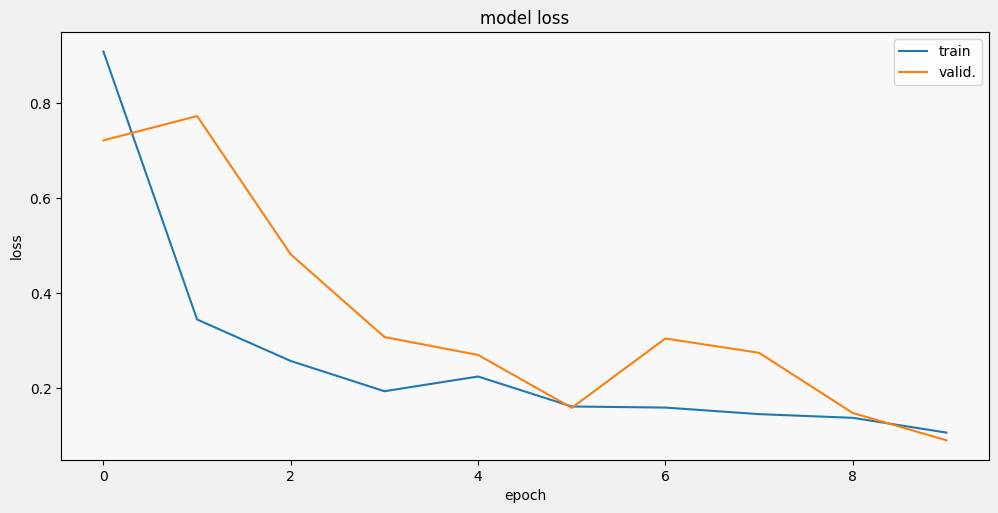

In [191]:
display_training_curves(
    history.history['loss'],
    history.history['val_loss'],
    'loss',
    211)

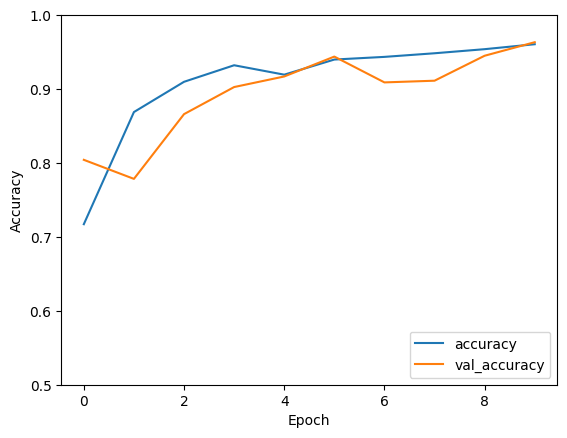

In [164]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

### Evaluating the model on Validation set

In [162]:
model.evaluate(val_generator)

55/55 [==============================] - 5s 85ms/step - loss: 0.0894 - accuracy: 0.9634


[0.08942217379808426, 0.9633657932281494]

### Visualisation of validation set prediction

1/1 [==============================] - 0s 35ms/step


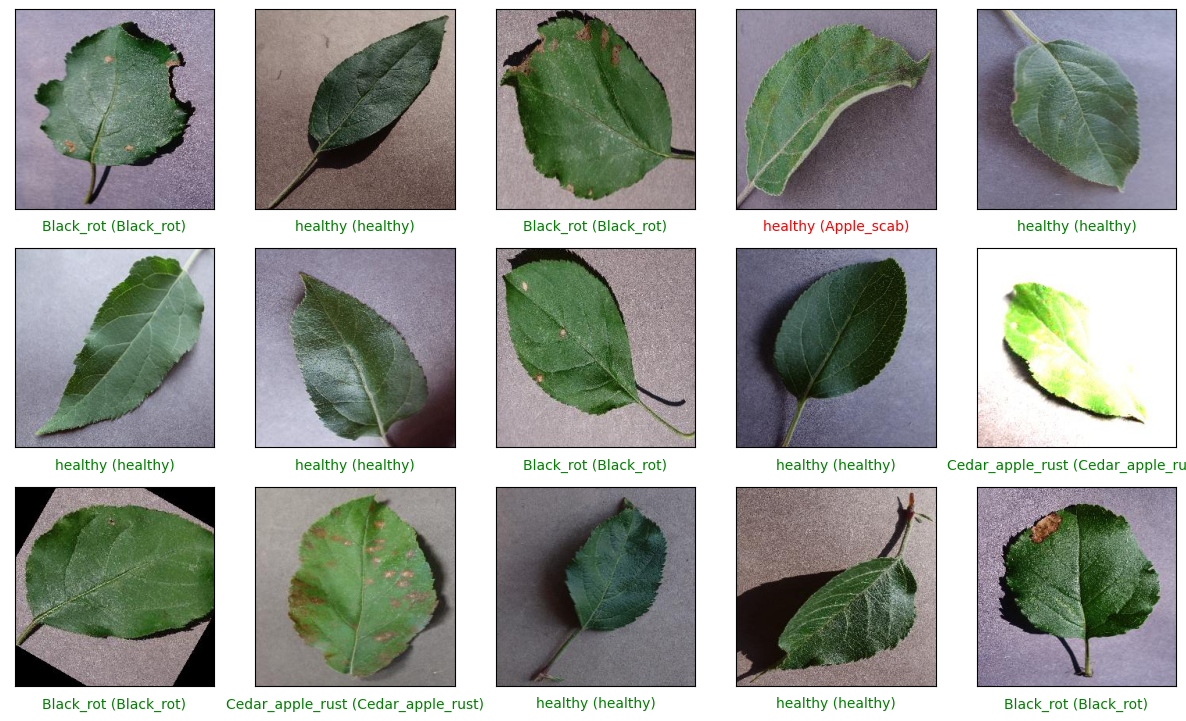

In [234]:
# Get a batch of images and labels from the validation set
images, labels = next(val_generator)

# Make predictions on the batch of images
predictions = model.predict(images)

# Define the class names
class_names = ['Apple_scab', 'Black_rot', 'Cedar_apple_rust', 'healthy']

# Plot the images and their predicted labels
plt.figure(figsize=(15, 15))
for i in range(15):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i], cmap=plt.cm.binary)
    predicted_label = np.argmax(predictions[i])
    true_label = np.argmax(labels[i])
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'
    plt.xlabel("{} ({})".format(class_names[predicted_label], class_names[true_label]), color=color)
plt.show()

### Make Test Prediction

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print('Test accuracy:', test_accuracy)

### Confusion Matrix

https://www.kaggle.com/code/ryanholbrook/create-your-first-submission